In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm

In [3]:
import cv2
from fastai import *
from fastai.vision import *

In [4]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

### Data Augmentation

In [5]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=15, max_lighting=0.15, max_zoom=1.0, max_warp=0.0)

In [6]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [8]:
pat = re.compile(r'^.*(hem|all).bmp$')
data  = (ImageDataBunch.from_name_re(path, fnames, pat, ds_tfms=tfms, size=224, bs=128, valid_pct=0.1)
       ).normalize()

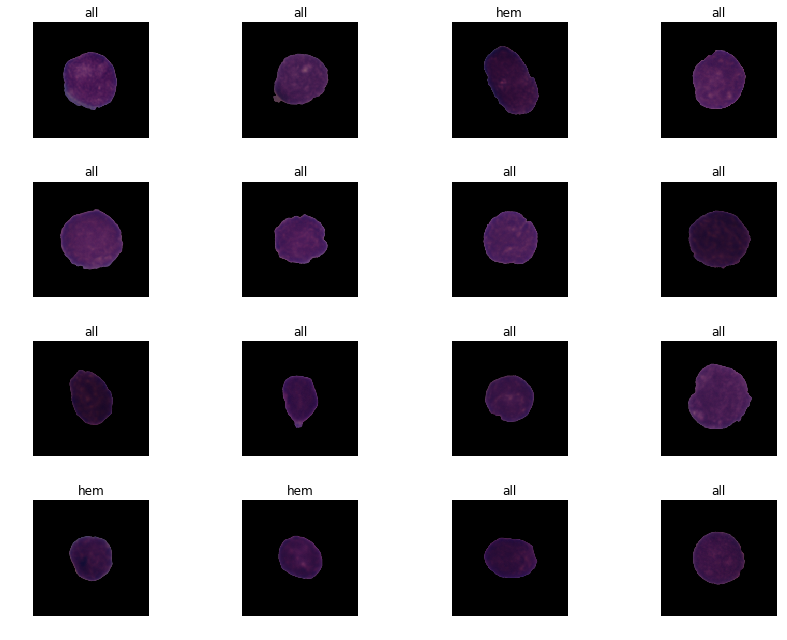

In [11]:
data.show_batch(rows=4, figsize=(12,9))

### ResNet - 18 half precision

In [15]:
learn = create_cnn(data, models.resnet18, metrics=[error_rate], callback_fns=[ShowGraph]).to_fp16()

/home/c.marzahl@de.eu.local/ProgProjekte/fastai_v1/fastai/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


### Find optimal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


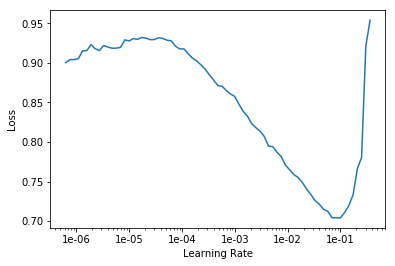

In [14]:
learn.lr_find()
learn.recorder.plot()

### Train head

epoch,train_loss,valid_loss,error_rate,time
0,0.469616,0.391953,0.166933,00:40
1,0.354317,0.305779,0.115815,00:40
2,0.300521,0.298429,0.116613,00:40
3,0.249104,0.217409,0.087859,00:40
4,0.219299,0.193752,0.071086,00:40


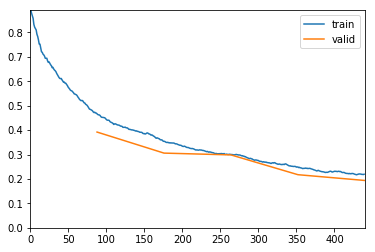

In [16]:
lr = 1e-2
learn.fit_one_cycle(5, lr)

### Fine tune the network

epoch,train_loss,valid_loss,error_rate,time
0,0.145125,0.145989,0.051917,00:41
1,0.146279,0.145224,0.051118,00:42
2,0.143668,0.146425,0.051917,00:42
3,0.146847,0.146401,0.050319,00:42
4,0.144192,0.145339,0.054313,00:41


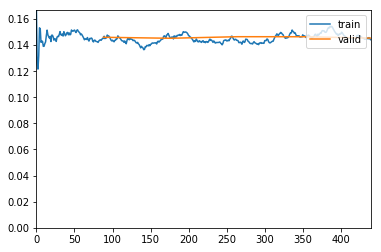

In [18]:
learn.unfreeze()

lr = 1e-3
learn.fit_one_cycle(5, lr)

# Test set error: 25%!!!